# Enhance ShopAssist AI (ShopAssist 2.0)





## Part 1: Introduction




#### Project Background

In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed **ShopAssist AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery**.


#### Problem Statement

*Given a dataset containing information about laptops (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate laptop recommendations based on user requirements*.


You can load the data and see it here.

In [5]:
# Install OpenAI library
#!pip install -q openai tenacity


In [52]:
# Import other libraries
import pandas as pd
from IPython.display import display, HTML
pd.set_option('display.width',100)

#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 laptops that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect laptop solution.

## Part 2: System Design


#### Dataset

We have a dataset `laptop_data.csv` where  each row describes the features of a single laptop and also has a small description at the end. The chatbot that we build will leverage LLMs to parse this `Description` column and provide recommendations

#### Workings of the Chatbot



The chatbot should ask a series of questions to
- Determine the user's requirments. For simplicity, we have used 6 features to encapsulate the user's needs. The 6 features are as follows:
    - GPU intensity
    - Display quality
    - Portability
    - Multitasking
    - Processing speed
    - Budget

- Confirm if the user's requirements have been correctly captured at the end.

After that the chatbot lists down the top 3 products that are the most relevant, and engages in further conversation to help the user find the best one.




# ShopAssist 1.0

#### Building the Chatbot

Below is the system design for the chatbot for **ShopAssist 1.0**.

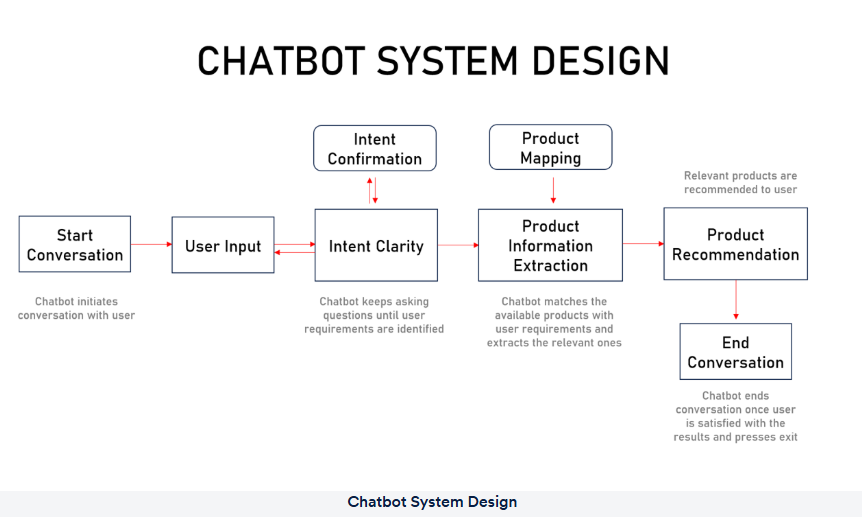

**Stage 1**

- Intent Clarity Layer
- Intent Confirmation Layer

**Stage 2**

- Product Mapping Layer
- Product Information Extraction Layer

**Stage 3**

- Product Recommendation Layer

##### Major functions behind the Chatbot ShopAssist

Let us now look at a brief overview of the major functions that form the chatbot and then deep live later:

- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_laptops_with_user()`: This function compares the user's profile with the different laptops and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

# ShopAssist 2.0

But in development of **ShopAssist2.0** , We have provided a method to combine function calling API with the ShopAssist AI 2.0's system design to make it more seamless, and with less lines of code!

This solution, redefines our system design, and refines the overall conversation flow. Also, the output of the layers are now more consistent and therefore, require less manipulation for a seamless conversation.

The architecture looks as shown below:

**Stage 1**

- Intent Clarity Layer

**Stage 2**

- Product Mapping Layer

**Stage 3**

- Product Recommendation Layer

The following layers from ShopAssist 1.0 **are removed** as their purpose are filled by now using **Function Calling** in OpenAI API.

1. intent_confirmation_layer()
2. dictionary_present()
3. initialize_conv_reco()

## Part 3: Implementation

## Part-2 System Design and Implementation - Stage 1

### 1.1 - Import the libraries

Importing libraries that are require for this project:
- openai
- os, json, ast
- pandas

Make sure the api key is stored in the text file `OPENAI_API_Key.txt` in your google drive linked above.

In [53]:
# Import the libraries
import os, json, ast
import openai
import re
#from tenacity import retry, wait_random_exponential, stop_after_attempt

In [54]:
# Read the OpenAI API key 
with open("OpenAI_API_Key.txt","r") as f:
  openai.api_key = ' '.join(f.readlines())

### 1.2 - Implementing Intent Clarity Layer


- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting (sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [55]:
def initialize_conversation():
    delimiter = "####"

    system_message = f"""
    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.
    You are trying to understand the user's requirement for these laptop's features: ('gpu intensity','display quality','portability','multitasking','processing speed','budget')
    You need to ask relevant questions and understand the user need for each feature by analysing the user's responses.
    After understanding their requirements, you'll use a function call to suggest the top 3 laptops with their respective user match score.
    Recommend these laptops and answer any user's query about them.

    {delimiter} Here are certain guidelines that you need to follow:
    Don't ask questions about more than 2 features at a time.
    If the user's budget is less than says less than 25000 INR, please mention that there are no laptops in that range.
    Recommend the top3 laptops in the following format:
    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:
    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    3. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    {delimiter}

    {delimiter}To find the top3 laptops, you need to have the following chain of thoughts:
    Thought 1: Ask one question to understand the user's profile and requirements. \n
    If their primary use for the laptop is unclear. Ask another question to comprehend their needs.
    Answer "Yes" or "No" to indicate if you understand the requirements. \n
    If yes, proceed to the next step. Otherwise, rephrase the question to capture their profile. \n

    Thought 2: Now, you are trying to understand the requirements for other features which you couldn't in the previous step.
    Ask questions to strengthen your understanding of the user's profile.
    Don't ask questions about more than 2 features at a time.
    Answer "Yes" or "No" to indicate if you understood all the needs of the features and are confident about the same.
    If yes, move to the next Thought. If no, ask question on the features whose needs you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the feature you want to understand the need for.{delimiter}
    {delimiter}

    {delimiter} Here is a sample conversation between the user and assistant:
    Assistant: "Hello! I'm here to help you find the perfect laptop that suits your needs. Could you please share your requirements?"
    User: "Hi, I am an editor."
    Assistant: "Great! As an editor, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. You would also need a high end display for better visuals and editing. May I know what kind of work do you primarily focus on? Are you more involved in video editing, photo editing, or both? Understanding the specific type of editing work will help me tailor my recommendations accordingly. Let me know if my understanding is correct until now."
    User: "I primarily work with After Effects."
    Assistant: "Thank you for providing that information. Working with After Effects involves working with graphics, animations, and rendering, which will require high GPU. Do you work with high-resolution media files, such as 4K videos or RAW photos? Understanding your file sizes will help determine the storage capacity and processing power needed."
    User: "Yes, sometimes I work with 4K videos as well."
    Assistant: "Thank you for the information. Processing 4K vidoes will require a good processor and high GPU. I think we have already determined earlier that you need a high GPU. To ensure I have a complete understanding of your needs, I have one more question: Are you frequently on the go and require a laptop that is lightweight and easy to carry, or do you primarily work from a stationary location?"
    User: "Yes, sometimes I travel but do not carry my laptop."
    Assistant:"Could you kindly let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1.5lakh inr"
    {delimiter}


    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message }]
    return conversation

Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

### Wrapper function to send messages to the GPT model and receive responses. Enables function calling capability via `function_call="auto"`

In [56]:
def get_chat_model_completions(messages):
    response = openai.chat.completions.create(
        model="gpt-4-0613",
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        max_tokens = 500,

        functions=function_descriptions,
        function_call="auto",
    )
    return response.choices[0].message

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [57]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

### Define the function that GPT can call: compare_laptops_with_user
##### This schema outlines the parameters GPT needs to collect from the user

In [58]:
## Function Description for the Function Calling API
function_descriptions = [
            {
                "name": "compare_laptops_with_user",
                "description": "Get the top 3 laptops from the catalogue, that best matches what the user is asking based on 'GPU intensity','Display quality','Portability','Multitasking','Processing speed' & 'Budget",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "gpu intensity": {
                            "type": "string",
                            "description": "The requirement of the user in GPU capacity classfied as low, medium or high" ,
                        },
                        "display quality": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's Display Quality & capacity classfied as low, medium or high" ,
                        },
                        "portability": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's portability classfied as low, medium or high" ,
                        },
                        "multitasking": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's Multitasking classfied as low, medium or high" ,
                        },
                        "processing speed": {
                            "type": "string",
                            "description": "The requirement of the user for Laptop's Processing speed classfied as low, medium or high" ,
                        },
                        "budget": {
                            "type": "integer",
                            "description": "The maximum budget of the user" ,
                        },

                    },
                    "required": ["GPU intensity","Display quality","Portability","Multitasking","Processing speed","Budget"],
                },
            }
        ]

## Stage 2

### 2.1 Implementing the Product Mapping


### `product_map_layer()`:

This function is responsible for extracting key features and criteria from laptop descriptions. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a Laptop Specifications Classifier, whose objective is to extract key features and classify them based on laptop descriptions.

- Provide step-by-step instructions for extracting laptop features from description.

- Assign specific rules for each feature (e.g., GPU Intensity, Display Quality, Portability, Multitasking, Processing Speed) and associate them with the appropriate classification value (Low, Medium, or High).

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process.

In [59]:
def product_map_layer(laptop_description):
    delimiter = "#####"

    prompt=f"""

    """

    input = f"""Follow the prompt instructions step-by-step and output the dictionary in JSON format for the following laptop {laptop_description}."""

    messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

    response = get_chat_model_completions(messages)

    return response.content

In [60]:
#testing product_map_layer
laptop_description_1 = f"""
The Dell Inspiron is a versatile laptop that combines powerful performance and affordability.
It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing.
With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity.
The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience.
Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage.
Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience.
With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment.
All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.
"""

In [61]:
display(product_map_layer(laptop_description_1))

'{\n  "brand": "Dell",\n  "model": "Inspiron",\n  "description": "The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6\\" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.",\n  "processor": "Intel Core i5",\n  "

Let's now apply this function to the entire laptop dataset

In [62]:
##Run this code once to extract product info in the form of a dictionary
laptop_df= pd.read_csv('laptop_data.csv')

In [63]:
laptop_df.columns

Index(['Brand', 'Model Name', 'Core', 'CPU Manufacturer', 'Clock Speed', 'RAM Size',
       'Storage Type', 'Display Type', 'Display Size', 'Graphics Processor', 'Screen Resolution',
       'OS', 'Laptop Weight', 'Special Features', 'Warranty', 'Average Battery Life', 'Price',
       'Description'],
      dtype='object')

In [64]:
# Understanding the text of Description column
print(laptop_df.Description)

0     The Dell Inspiron is a versatile laptop that c...
1     The MSI GL65 is a high-performance laptop desi...
2     The HP EliteBook is a premium laptop designed ...
3     The Lenovo IdeaPad is a versatile laptop that ...
4     The ASUS ZenBook Pro is a high-end laptop that...
5     The Acer Predator is a powerhouse laptop desig...
6     The Microsoft Surface Laptop is a premium devi...
7     The Lenovo ThinkPad is a powerful laptop desig...
8     The HP Pavilion is a budget-friendly laptop th...
9     The ASUS ROG Strix G is a high-performance gam...
10    The Dell XPS 15 is a premium laptop that combi...
11    The Lenovo ThinkPad X1 Carbon is a sleek and l...
12    The Acer Swift 3 is a lightweight and affordab...
13    The Apple MacBook Air is a sleek and lightweig...
14    The MSI Prestige 14 is a compact and stylish l...
15    The ASUS ZenBook 13 is a lightweight and power...
16    The Dell Precision 5550 is a high-performance ...
17    The HP ENVY x360 is a versatile 2-in-1 con

In [65]:
## Create a new column "laptop_feature" that contains the dictionary of the product features
laptop_df['laptop_feature'] = laptop_df['Description'].apply(lambda x: product_map_layer(x))

In [66]:
# checking for the laptop_feature column
laptop_df.columns

Index(['Brand', 'Model Name', 'Core', 'CPU Manufacturer', 'Clock Speed', 'RAM Size',
       'Storage Type', 'Display Type', 'Display Size', 'Graphics Processor', 'Screen Resolution',
       'OS', 'Laptop Weight', 'Special Features', 'Warranty', 'Average Battery Life', 'Price',
       'Description', 'laptop_feature'],
      dtype='object')

In [67]:
# checking the data in laptop_feature column
print(laptop_df.laptop_feature)

0     {\n  "brand": "Dell",\n  "model": "Inspiron",\...
1     {\n  "name": "MSI GL65",\n  "description": "Th...
2     {\n  "brand": "HP",\n  "model": "EliteBook",\n...
3     {\n  "brand": "Lenovo",\n  "model": "IdeaPad",...
4     {\n  "name": "ASUS ZenBook Pro",\n  "descripti...
5     {\n  "name": "Acer Predator",\n  "description"...
6     {\n  "name": "Microsoft Surface Laptop",\n  "d...
7     {\n  "brand": "Lenovo",\n  "model": "ThinkPad"...
8     {\n  "brand": "HP",\n  "model": "Pavilion",\n ...
9     {\n  "brand": "ASUS",\n  "model": "ROG Strix G...
10    {\n  "brand": "Dell",\n  "model": "XPS 15",\n ...
11    {\n  "name": "Lenovo ThinkPad X1 Carbon",\n  "...
12    {\n  "name": "Acer Swift 3",\n  "description":...
13    {\n  "name": "Apple MacBook Air",\n  "descript...
14    {\n  "name": "MSI Prestige 14",\n  "descriptio...
15    {\n  "name": "ASUS ZenBook 13",\n  "descriptio...
16    {\n  "name": "Dell Precision 5550",\n  "descri...
17    {\n  "name": "HP ENVY x360",\n  "descripti

In [68]:
laptop_df.head(5)

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description,laptop_feature
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...,"{\n ""brand"": ""Dell"",\n ""model"": ""Inspiron"",\..."
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...,"{\n ""name"": ""MSI GL65"",\n ""description"": ""Th..."
2,HP,EliteBook,i7,Intel,2.8 GHz,16GB,SSD,LED,"14""",Intel UHD,1920x1080,Windows 11,1.5 kg,Fingerprint Sensor,3 years,8 hours,"90,000",The HP EliteBook is a premium laptop designed ...,"{\n ""brand"": ""HP"",\n ""model"": ""EliteBook"",\n..."
3,Lenovo,IdeaPad,i3,Intel,2.1 GHz,8GB,HDD,TN,"15.6""",Intel UHD,1366x768,Windows 10,2.2 kg,Dolby Audio,1 year,5 hours,"25,000",The Lenovo IdeaPad is a versatile laptop that ...,"{\n ""brand"": ""Lenovo"",\n ""model"": ""IdeaPad"",..."
4,ASUS,ZenBook Pro,i9,Intel,3.1 GHz,64GB,SSD,OLED,"15.6""",NVIDIA RTX,3840x2160,Windows 10,1.8 kg,NanoEdge Display,2 years,7 hours,"200,000",The ASUS ZenBook Pro is a high-end laptop that...,"{\n ""name"": ""ASUS ZenBook Pro"",\n ""descripti..."


In [69]:
## Save this updated csv file so that it can used next time and we do not need to perform this again until we have new details.
laptop_df.to_csv("updated_laptop.csv",index=False,header = True)

## Stage 3

### 3.1: Product Recommendation Layer

The final stage is the product recommendation layer. It utilizes the output from the 'compare_laptops_with_user' function and delivers the results to the user. This layer performs the following actions:
1. Continues the dialogue to guide the recommendation process.
2. Formats and presents the recommended laptops in a user-friendly manner.
3. Engages the user with follow-up questions based on the provided recommendations.



In [70]:
def extract_dictionary_from_string(string):
    regex_pattern = r"\{[^{}]+\}"

    dictionary_matches = re.findall(regex_pattern, string)

    # Extract the first dictionary match and convert it to lowercase
    if dictionary_matches:
        dictionary_string = dictionary_matches[0]
        dictionary_string = dictionary_string.lower()
        # Convert the dictionary string to a dictionary object using ast.literal_eval()
        #dictionary = json.loads(dictionary_string)
        dictionary = ast.literal_eval(dictionary_string)
    return dictionary

### `compare_laptops_with_user()`:

This function evaluates the user's profile against available laptops and returns the top recommendations. It follows these steps:
    - Accepts a dictionary of user requirements as input.

    - Filters the laptops to include only those within the user's budget.

    - Assigns a score to each laptop based on how closely it aligns with the user's preferences.

    - Sorts the laptops in descending order of their scores.
    
    - Returns the top three laptops in a JSON-formatted string.

In [72]:
def compare_laptops_with_user(user_req_string):
  budget = user_req_string.get('budget', '0')
  laptop_df= pd.read_csv('updated_laptop.csv')
  filtered_laptops = laptop_df.copy()
  filtered_laptops['Price'] = filtered_laptops['Price'].str.replace(',','').astype(int)
  filtered_laptops = filtered_laptops[filtered_laptops['Price'] <= budget].copy()

  mappings = {
          'low': 0,
          'medium': 1,
          'high': 2
      }
  # Create 'Score' column in the DataFrame and initialize to 0
  filtered_laptops['Score'] = 0
  for index, row in filtered_laptops.iterrows():
      user_product_match_str = row['laptop_feature']
      laptop_values = extract_dictionary_from_string(user_product_match_str)
      score = 0

      for key, user_value in user_req_string.items():
        if key.lower() == 'budget':
            continue  # Skip budget comparison

        laptop_value = laptop_values.get(key, None)

        if not isinstance(laptop_value, str) or not isinstance(user_value, str):
          continue

        laptop_mapping = mappings.get(laptop_value.lower(), -1)
        user_mapping = mappings.get(user_value.lower(), -1)
        if laptop_mapping >= user_mapping:
          ### If the laptop value is greater than or equal to the user value the score is incremented by 1
          score += 1

      filtered_laptops.loc[index, 'Score'] = score

  # Sort the laptops by score in descending order and return the top 5 products
  top_laptops = filtered_laptops.drop('laptop_feature', axis=1)
  top_laptops = top_laptops.sort_values('Score', ascending=False).head(3)

  return top_laptops.to_json(orient='records')

### Filters recommended laptops based on minimum match score threshold
#### Ensures only relevant suggestions are shown to the user

In [73]:
def recommendation_validation(laptop_recommendation):

    data = json.loads(laptop_recommendation)
    data1 = []
    for i in range(len(data)):
      if data[i]['Score'] > 2:
        data1.append(data[i])

    return json.dumps(data1)

## Stage 4 - Combining all the 3 stages

Now, we will combine all three stages that we defined above.

**Stage 1** + **Stage 2** + **Stage 3**

### 4.1 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [74]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()
    introduction = get_chat_model_completions(conversation).content
    print(introduction + '\n')
    user_input = ""
    while(user_input != "exit"):
      user_input = input("")
      moderation = moderation_check(user_input)
      if moderation == 'Flagged':
          display("Sorry, this message has been flagged. Please restart your conversation.")
          break
      conversation.append({"role": "user", "content": user_input})
      # Step 1: Pass the user input to GPT
      response_assistant = get_chat_model_completions(conversation)
      if response_assistant.function_call:
        print("\nThank you for providing all the information. Kindly wait, while I fetch the products\n")
        # Step 2: Extract top3 laptops by calling the external function
        function_name = response_assistant.function_call.name
        function_args = json.loads(response_assistant.function_call.arguments)
        print(f"User requirement: {function_args}")
        top_3_laptops = compare_laptops_with_user(function_args)
        function_response = recommendation_validation(top_3_laptops)
        if len(function_response) == 0:
          print("Sorry, we do not have laptops that match your requirements. Connecting you to a human expert.")
          break
        # Step 3: send the info on the function call and function response to GPT
        conversation.append(response_assistant)
        conversation.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )
        recommendation = get_chat_model_completions(conversation)
        conversation.append({"role": "assistant", "content": recommendation.content})
        print("\n" +recommendation.content + "\n")
      else:
        conversation.append({"role": "assistant", "content": response_assistant.content})
        print("\n" +  response_assistant.content + "\n")

In [79]:
#Chatbot API - Dialogue Management System-1
dialogue_mgmt_system()

Assistant: "Hello! I'm here to help you find the perfect laptop that suits your needs. Could you please share your requirements?"



 i want laptop for gaming



Great! Gaming laptops require high GPU intensity and processing speed for smooth gameplay. Could you please tell me more about the types of games you play? Are they high-end games with heavy graphics? Also, do you prefer a high-quality display for a better gaming experience?



 good graphics and fhd display required



Thank you for the information. It seems like you need a laptop with high GPU intensity and a high-quality display. Now, let's talk about portability and multitasking. Do you travel often and need a laptop that's easy to carry? Also, do you often run multiple applications or games at the same time?



 i wont carry laptop and i will do multitasking



Thank you for the information. So, you need a laptop with high GPU intensity, high-quality display, and high multitasking capability, but portability is not a priority for you. Could you please share your budget for the laptop? This will help me find the best options within your price range.



 95k



Thank you for providing all the information. Kindly wait, while I fetch the products

User requirement: {'gpu intensity': 'high', 'display quality': 'high', 'portability': 'low', 'multitasking': 'high', 'budget': 95000}

Based on your requirements, here are the top 2 laptops that I would recommend:

1. Acer Predator: This laptop is equipped with an Intel Core i7 processor clocked at 2.8 GHz, providing exceptional processing power for seamless gaming and demanding tasks. It has 16GB of RAM and an SSD for fast and efficient multitasking and storage capabilities. The laptop features a large 17.3" IPS display with a resolution of 1920x1080, delivering stunning visuals. It also comes with an NVIDIA GTX graphics card for impressive gaming performance. The laptop features dual cooling fans for effective heat dissipation during intense gaming sessions. It weighs 3.2 kg and has a battery life of up to 5 hours. The price is 80,000 INR.

2. HP ENVY x360: This is a versatile 2-in-1 convertible la

 which one more portable among them



The HP ENVY x360 is more portable among the two. It weighs 2.05 kg, which is lighter than the Acer Predator that weighs 3.2 kg. Additionally, the HP ENVY x360 has a 2-in-1 convertible design, which can add to its portability and versatility.



 exit



Sure, if you have any more questions in the future, feel free to ask. Have a great day!



In [48]:
#Chatbot API - Dialogue Management System-2
dialogue_mgmt_system()

Assistant: "Hello! I'm here to help you find the perfect laptop that suits your needs. Could you please share your requirements?"



 help me with a trip to italy for 4 days



I'm sorry for the confusion, but as a laptop gadget expert, I can assist you in finding the perfect laptop based on your needs. However, I'm not equipped to help with travel plans. If you need help with laptops, feel free to share your requirements.



 exit



Sure, feel free to return if you need any assistance in the future. Have a great day!



In [49]:
#Chatbot API - Dialogue Management System-3
dialogue_mgmt_system()

Assistant: "Hello! I'm here to help you find the perfect laptop that suits your needs. Could you please share your requirements?"



 laptop for coding



Great! Coding requires a laptop with good processing speed and multitasking capabilities. Could you please tell me more about the type of coding you do? Are you a web developer, app developer, or do you work with data science? Also, do you prefer a laptop with high portability, meaning lightweight and easy to carry?



 data science related



Excellent! For data science, you would need a laptop with high processing speed and multitasking capabilities to handle large datasets and run complex algorithms. A good quality display would also be beneficial for data visualization. 

Could you please tell me about your preferences for GPU intensity? Do you work with a lot of graphical data or machine learning algorithms that might require a high-end GPU? Also, could you share your budget for the new laptop?



 medium



Thank you for the information. So, you require a laptop with medium GPU intensity. 

Could you please specify your budget for the new laptop? This will help me find the best options within your price range.



 85k



Thank you for providing all the information. Kindly wait, while I fetch the products

User requirement: {'gpu intensity': 'medium', 'display quality': 'high', 'portability': 'medium', 'multitasking': 'high', 'processing speed': 'high', 'budget': 85000}

Here are the top 2 laptops that match your requirements:

1. Lenovo ThinkPad: Equipped with a Ryzen 7 processor from AMD clocked at 3.0 GHz, 16GB of RAM, and an SSD, it offers smooth multitasking and fast storage access. The laptop features a 14" IPS display with a resolution of 2560x1440, delivering sharp visuals and accurate colors. It also comes with an NVIDIA GTX graphics card for enhanced graphical performance. Weighing just 1.6 kg, it is lightweight and highly portable. The laptop features a backlit keyboard for comfortable typing in low-light environments. With a three-year warranty and a battery life of up to 6 hours, the Lenovo ThinkPad offers reliability and durability. Priced at 60,000 INR.

2. Acer Predator: Equipped with a

 exit



Sure, feel free to reach out if you have more questions in the future. Have a great day!

